## 原始数据整理

In [ ]:
import os

path = r"I:\dataset\Med\2023_Med_CQK\label"

for folder_name in os.listdir(path):
    if folder_name[0].isdigit():
        new_folder_name = folder_name.lstrip('0123456789')
        print(f'{folder_name:7s} -> {new_folder_name:7s}')
        os.rename(os.path.join(path, folder_name), os.path.join(path, new_folder_name))

In [ ]:
import os
import glob
from pypinyin import lazy_pinyin

# 要在2号文件夹中找到1号文件夹所对应的数据
root = r'I:\dataset\Med\2023_Med_CQK'
folder1 = os.path.join(root, 'label')
folder2 = os.path.join(root, 'img')

# 列出两个文件夹中的文件名
names1_origin = os.listdir(folder1)     # label
names2_origin = os.listdir(folder2)     # img

# 将中文人名转换为拼音
def convert_to_pinyin(name):
    # 使用lazy_pinyin函数将中文转换为拼音
    return ''.join(lazy_pinyin(name))

names1 = [convert_to_pinyin(name) for name in names1_origin]
names2 = [convert_to_pinyin(name) for name in names2_origin]

# 大写拼音转小写拼音并去除空格
names1 = [name.lower().replace(' ', '') for name in names1]
names2 = [name.lower().replace(' ', '') for name in names2]

success_count=0
failed_count=0
modify_list=[]

# 比较两个文件夹中的人名是否对应
for i, label_name in enumerate(names1):
    label_name = label_name.rstrip('0123456789')
    if label_name in names2:
        # 定位索引
        index = names2.index(label_name)
        # 打印对应的文件名
        # print(f'{names1_origin[i]} -> {names2_origin[index]}')

        pinyin = names1_origin[i]
        # 如果pinyin不是拼音是中文，则直接跳过
        if pinyin.isalpha():        # 包含数字或空格会被isalpha认为False，中文则是True
            print(f'{pinyin} 不是拼音，跳过')
            continue
        # 如果label拼音最后一个字母是数字，则记录下来
        if pinyin[-1].isdigit():
            target_folder_name = names2_origin[index]+pinyin[-1]
        else:
            target_folder_name = names2_origin[index]
        modify_list.append((names1_origin[i], target_folder_name))
    else:
        # 使用命令行特殊符号指定红色
        print('\033[31m' + f'{names1_origin[i]} ({label_name}) 失败' + '\033[0m')
        failed_count += 1

# 打印失败的数量
print(f'{failed_count} 失败')
for item in modify_list:
    print(item)

# 将label文件夹中的文件名修改为img文件夹中的文件名
for item in modify_list:
    src = os.path.join(folder1, item[0])
    dst = os.path.join(folder1, item[1])
    print(f'{src} -> {dst}')
    os.rename(src, dst)


In [ ]:
import shutil

for item in modify_list:
    src = os.path.join(folder1, item[0])
    dst = os.path.join(folder1, item[1])
    try:
        for root, dirs, files in os.walk(src):
            if dirs != []:
                raise Exception('文件夹中还有文件夹')
            for file in files:
                if not os.path.exists(os.path.join(root, file)):
                    raise FileNotFoundError(f'{os.path.join(root, file)} 不存在')
                print(f'{os.path.join(root, file)} -> {dst}')
                if not os.path.exists(dst):
                    os.makedirs(dst)
                shutil.move(os.path.join(root, file), dst)  # 这个无语函数dst是动态决定的，可以是folder也可以是file，如果找不到目录就直接命名在当前目录下了，这么烂的函数谁想的出来的，循环调用的时候全自我覆盖掉了，我真无语
            # 如果移动后文件夹为空，则删除
            if os.listdir(src) == []:
                os.rmdir(src)
    except Exception as e:
        print(e)

## DCM读取

In [11]:
import pydicom

# 读取DICOM文件
dcm = pydicom.dcmread('./data/2023_Med_CQK/img_origin/train/丁佳能/丁佳能_ImageFileName073.dcm')


# 访问DICOM文件中的元数据 (20,1041)
# (0020, 1041) Slice Location                      DS: '-184.656'
print(dcm.get('SliceLocation'))
print(dcm)

# 访问DICOM文件中的像素数据
pixels = dcm.pixel_array

-275.906
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 218
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113619.2.416.1704582321615852459138124053246771085.74
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMBP_360'
(0002, 0016) Source Application Entity Title     AE: 'revo'
-------------------------------------------------
(0008, 0000) Group Length                        UL: 882
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20170112'
(0008, 0013) Instanc

注意dcm各切片中的(0020, 1041)Slice Location参数，代表了切片的轴向坐标，其可以与下方nrrd元数据的space origin对应。

(0020, 0032) Image Position参数也能对应

## NRRD最大切面标注读取

(512, 512, 1) <class 'numpy.ndarray'>
-54.63700000000002


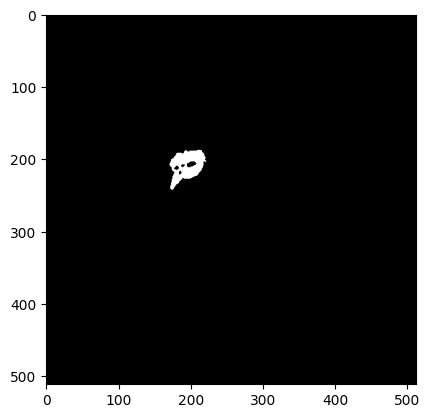

(512, 512, 1)
[0.]


In [21]:
import nrrd
import numpy as np

data, header = nrrd.read('./data/2023_Med_CQK/label_origin/test/张国才/张国才_mask.nrrd')
print(data.shape, type(data))
print(header['space origin'][2])
# for item in header.items():
#     print(item)
import matplotlib.pyplot as plt
plt.imshow(data, cmap='gray')
plt.show()

data = data.astype(np.float32)
print(data.shape)
print(data[300,250])

## 指定目录 Nrrd标注与nrrd原图转换为npy

In [18]:
import nrrd
import numpy as np
from PIL import Image

# 递归整个目录，把所有nrrd文件，在所在位置生成一份png副本
def nrrd2png(path):
	for root, dirs, files in os.walk(path):
		for file in files:
			if file.endswith('.nrrd'):
				nrrd_file = os.path.join(root, file)
				data, header = nrrd.read(nrrd_file)
				print(data.shape)
				print(data[255,255,0])
				data = data.astype(np.float32)
				print(data[255,255,0])
				npy_file = nrrd_file.replace('.nrrd', '.npy')
				print(type(data), data.shape)
				# 原地保存npy副本
				break
				np.save(npy_file, data)
				print(file, '<----->', npy_file)

nrrd2png('./data/2023_Med_CQK/reconstructed_img_label_pair/img')

(512, 512, 1)
-86
-86.0
<class 'numpy.ndarray'> (512, 512, 1)
(512, 512, 1)
-62
-62.0
<class 'numpy.ndarray'> (512, 512, 1)
(512, 512, 1)
154
154.0
<class 'numpy.ndarray'> (512, 512, 1)
(512, 512, 1)
-71
-71.0
<class 'numpy.ndarray'> (512, 512, 1)
(512, 512, 1)
93
93.0
<class 'numpy.ndarray'> (512, 512, 1)
(512, 512, 1)
74
74.0
<class 'numpy.ndarray'> (512, 512, 1)
(512, 512, 1)
-30
-30.0
<class 'numpy.ndarray'> (512, 512, 1)
(512, 512, 1)
130
130.0
<class 'numpy.ndarray'> (512, 512, 1)
(512, 512, 1)
73
73.0
<class 'numpy.ndarray'> (512, 512, 1)
(512, 512, 1)
182
182.0
<class 'numpy.ndarray'> (512, 512, 1)
(512, 512, 1)
63
63.0
<class 'numpy.ndarray'> (512, 512, 1)
(512, 512, 1)
8
8.0
<class 'numpy.ndarray'> (512, 512, 1)
(512, 512, 1)
-62
-62.0
<class 'numpy.ndarray'> (512, 512, 1)
(512, 512, 1)
22
22.0
<class 'numpy.ndarray'> (512, 512, 1)
(512, 512, 1)
45
45.0
<class 'numpy.ndarray'> (512, 512, 1)
(512, 512, 1)
-66
-66.0
<class 'numpy.ndarray'> (512, 512, 1)
(512, 512, 1)
-40
-40.0


## LMDB数据库检查和Torch读取测试

In [ ]:
import lmdb, io
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torch

env = lmdb.Environment('./data/2023_Med_CQK/img/lmdb', readonly=True, lock=False, readahead=False, meminit=False)
txn = env.begin(write=False)
print(env.stat())
# # 遍历数据库
# i=10
# for key, value in txn.cursor():
#     if i<=0:
#         break
#     print(key.decode(), value)
#     i-=1

# 读取key为'丁佳能_ImageFileName000.png'的数据
key = '丁佳能_ImageFileName000.png'.encode()
value = txn.get(key)
img = io.BytesIO(value)
img = Image.open(img)
img = np.array(img)
print(img.dtype)
# 归一化并转换为half类型
img = (img/65535)
print(img.dtype)
print(img[200,200])
plt.imshow(img, cmap='gray')
# 标准化
img = (img-img.mean())/img.std()

tensor = torch.from_numpy(img).half()
print(tensor[200,200])
print(tensor.dtype)

## 文件名修改

In [ ]:
# 在指定目录下，在所有dcm、png、nrrd文件的文件名之前加入自己的父目录名
import os, tqdm

def rename_files(directory):
	for root, dirs, files in tqdm.tqdm(os.walk(directory)):
		for filename in files:
			# 获取文件的完整路径
			filepath = os.path.join(root, filename)
			# 获取文件的父目录名
			parent_dirname = os.path.basename(os.path.dirname(filepath))
			grandparent_dirname = os.path.basename(os.path.dirname(os.path.dirname(filepath)))
			# 如果父目录是A或者PV或者V，则再加入更上一级的目录名
			if parent_dirname in ['A', 'PV', 'V']:
				parent_dirname = grandparent_dirname + '_' + parent_dirname
			# 构造新的文件名，限定文件类型生效
			if filename.endswith('.dcm') or filename.endswith('.png') or filename.endswith('.nrrd'):
				new_filename = parent_dirname + "_" + filename
				new_filepath = os.path.join(root, new_filename)
				# 重命名文件
				# print(f'{filepath} -> {new_filepath}')
				os.rename(filepath, new_filepath)
			else:
				print(f'{filepath} 不是dcm或png或nrrd文件，跳过')

root = r'D:\PostGraduate\DL\ClassicDataset\2023_Med_CQK'
rename_files(root)

## 把标注文件的名称前缀全部对应到其原始扫描文件的名称前缀

In [1]:
import os, nrrd, pydicom, pdb, shutil

# 指定单次扫描集，返回指定location的切片文件名
def get_slice_location(img_root:str, location, relative_path:str):
	imgs_folder = os.path.join(img_root, relative_path)
	for dcm_files in os.listdir(imgs_folder):
		if dcm_files.endswith('.dcm'):
			dcm = pydicom.dcmread(os.path.join(imgs_folder,dcm_files))
			# (0020, 1041) Slice Location                      DS: '-184.656'
			current_location = dcm.get('SliceLocation')
			# 绝对值差不超过0.5的就认为是同一张切片
			if abs(current_location - location) < 0.01:
				# print(f'{location:.4f} <---> {current_location:.4f}')
				return os.path.join(imgs_folder, dcm_files)
	else:
		raise Exception


def build_dcm_nrrd_pair(root:str):
	img_folder = os.path.join(root, 'img_origin')
	label_folder = os.path.join(root, 'label_origin')

	for scan_folder, dirs, files in os.walk(label_folder):
		for filename in files:
			if not filename.endswith('_mask.nrrd'): continue
			filepath = os.path.join(scan_folder, filename)	# nrrd文件的完整路径

			# 获取nrrd文件中的space origin
			data, header = nrrd.read(filepath)
			nrrd_slice_position = header['space origin'][2]
			# 获取root与img文件夹的相对路径
			relative_path = os.path.relpath(scan_folder, label_folder)

			try:
				# 执行匹配
				dcm_filepath_according_to_nrrd_anno = get_slice_location(img_folder, nrrd_slice_position, relative_path)
				filepath_relative_to_root = os.path.relpath(filepath, root)
				found_dcm_filepath_relative_to_root = os.path.relpath(dcm_filepath_according_to_nrrd_anno, root)
				# print(f'匹配成功：{filepath_relative_to_root} <----> {found_dcm_filepath_relative_to_root}')
				# 匹配到的dcm文件名，并将后缀改为nrrd
				modified_image_filename = dcm_filepath_according_to_nrrd_anno.replace('.dcm', '.png')		# 取dcm对应切片的png文件
				modified_anno_filename = dcm_filepath_according_to_nrrd_anno.replace('.dcm', '.nrrd')		# 对齐标注文件名和dcm对应切片文件名

				# 确定两者的副本保存路径
				png_image_path_to_save = os.path.join(root, 'img', *filepath_relative_to_root.split(os.sep)[1:-1], os.path.basename(modified_image_filename))
				nrrd_anno_path_to_save = os.path.join(root, 'label', *filepath_relative_to_root.split(os.sep)[1:-1], os.path.basename(modified_anno_filename))
				
				# 执行复制
				if not os.path.exists(os.path.dirname(png_image_path_to_save)):
					os.makedirs(os.path.dirname(png_image_path_to_save))
				print(f'图片复制：{modified_image_filename} ---> {png_image_path_to_save}')
				shutil.copyfile(modified_image_filename, png_image_path_to_save)
				if not os.path.exists(os.path.dirname(nrrd_anno_path_to_save)):
					os.makedirs(os.path.dirname(nrrd_anno_path_to_save))
				print(f'标注复制：{filepath} ---> {nrrd_anno_path_to_save}')
				shutil.copyfile(filepath, nrrd_anno_path_to_save)


			except Exception as e:
				print(os.path.relpath(filepath, root), e)

root = r'D:\PostGraduate\DL\ClassicDataset\2023_Med_CQK'
build_dcm_nrrd_pair(root)

图片复制：D:\PostGraduate\DL\ClassicDataset\2023_Med_CQK\img_origin\test\仲才发\A\仲才发_A_ImageFileName077.png ---> D:\PostGraduate\DL\ClassicDataset\2023_Med_CQK\img\test\仲才发\A\仲才发_A_ImageFileName077.png
标注复制：D:\PostGraduate\DL\ClassicDataset\2023_Med_CQK\label_origin\test\仲才发\A\仲才发_A_mask.nrrd ---> D:\PostGraduate\DL\ClassicDataset\2023_Med_CQK\label\test\仲才发\A\仲才发_A_ImageFileName077.nrrd
图片复制：D:\PostGraduate\DL\ClassicDataset\2023_Med_CQK\img_origin\test\仲才发\PV\仲才发_PV_ImageFileName074.png ---> D:\PostGraduate\DL\ClassicDataset\2023_Med_CQK\img\test\仲才发\PV\仲才发_PV_ImageFileName074.png
标注复制：D:\PostGraduate\DL\ClassicDataset\2023_Med_CQK\label_origin\test\仲才发\PV\仲才发_PV_mask.nrrd ---> D:\PostGraduate\DL\ClassicDataset\2023_Med_CQK\label\test\仲才发\PV\仲才发_PV_ImageFileName074.nrrd
图片复制：D:\PostGraduate\DL\ClassicDataset\2023_Med_CQK\img_origin\test\周云清\A\周云清_A_ImageFileName080.png ---> D:\PostGraduate\DL\ClassicDataset\2023_Med_CQK\img\test\周云清\A\周云清_A_ImageFileName080.png
标注复制：D:\PostGraduate\DL\Class

## 将label文件夹组织为mmseg支持的数据集组织结构

In [5]:
import os, shutil

root = r'D:\PostGraduate\DL\ClassicDataset\2023_Med_CQK'
label_folder = os.path.join(root, 'label')

for folder, dir, files in os.walk(label_folder):
	# 对于所有的nrrd文件，获得他们相对于label文件夹的相对路径
	for filename in files:
		if not filename.endswith('.nrrd'): continue
		relative_path = os.path.relpath(os.path.join(folder, filename), label_folder)

		# 如果其文件名包含mask，则在relative_path的开头加上label
		if 'mask' in filename:
			relative_path = os.path.join('label', relative_path)
		elif 'image' in  filename:
			relative_path = os.path.join('img', relative_path)
		else:
			print(f'{filename} 不是mask或image文件，跳过')
			continue
		
		# 组成最终路径
		desc_path = os.path.join(root, 'reconstructed_img_label_pair', relative_path).replace('_image', '').replace('_mask', '')
		# 如果文件夹不存在，则创建
		if not os.path.exists(os.path.dirname(desc_path)):
			os.makedirs(os.path.dirname(desc_path))
		
		# 执行复制
		shutil.copyfile(os.path.join(folder, filename), desc_path)
		
		print(f'{filename} ---> {desc_path}')
			

仲才发_A_image.nrrd ---> D:\PostGraduate\DL\ClassicDataset\2023_Med_CQK\reconstructed_img_label_pair\img\test\仲才发\A\仲才发_A.nrrd
仲才发_A_mask.nrrd ---> D:\PostGraduate\DL\ClassicDataset\2023_Med_CQK\reconstructed_img_label_pair\label\test\仲才发\A\仲才发_A.nrrd
仲才发_PV_image.nrrd ---> D:\PostGraduate\DL\ClassicDataset\2023_Med_CQK\reconstructed_img_label_pair\img\test\仲才发\PV\仲才发_PV.nrrd
仲才发_PV_mask.nrrd ---> D:\PostGraduate\DL\ClassicDataset\2023_Med_CQK\reconstructed_img_label_pair\label\test\仲才发\PV\仲才发_PV.nrrd
周云清_A_image.nrrd ---> D:\PostGraduate\DL\ClassicDataset\2023_Med_CQK\reconstructed_img_label_pair\img\test\周云清\A\周云清_A.nrrd
周云清_A_mask.nrrd ---> D:\PostGraduate\DL\ClassicDataset\2023_Med_CQK\reconstructed_img_label_pair\label\test\周云清\A\周云清_A.nrrd
周云清_PV_image.nrrd ---> D:\PostGraduate\DL\ClassicDataset\2023_Med_CQK\reconstructed_img_label_pair\img\test\周云清\PV\周云清_PV.nrrd
周云清_PV_mask.nrrd ---> D:\PostGraduate\DL\ClassicDataset\2023_Med_CQK\reconstructed_img_label_pair\label\test\周云清\PV\周云清_

## nrrd文件维度纠错

在训练时，发现出现了nrrd标注文件尺度不为(512,512,1)，此处建立脚本找到该标注并进一步修复问题

In [6]:
import nrrd

root = r'D:/PostGraduate/DL/mgam_CT/data/2023_Med_CQK'

# 遍历所有nrrd文件
for folder, dir, files in os.walk(root):
	for filename in files:
		if not filename.endswith('.nrrd'): continue
		data, header = nrrd.read(os.path.join(folder, filename))
		if data.shape != (512,512,1):
			print(os.path.join(folder, filename), data.shape)

D:/PostGraduate/DL/mgam_CT/data/2023_Med_CQK\label\test\周昌秀\PV\周昌秀_PV_ImageFileName192.nrrd (512, 512, 193)
D:/PostGraduate/DL/mgam_CT/data/2023_Med_CQK\label_origin\test\周昌秀\PV\周昌秀_PV_mask.nrrd (512, 512, 193)


(512, 512, 193)
1
90


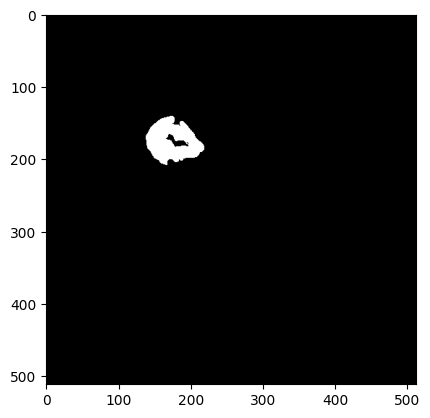

In [1]:
import nrrd
import matplotlib.pyplot as plt

data, header = nrrd.read(r'D:/PostGraduate/DL/mgam_CT/data/2023_Med_CQK/label_origin/test/周昌秀/PV/周昌秀_PV_mask.nrrd')
print(data.shape)
# 打印data最大值
print(data.max())

# 检查在第三维度上，每个维度的数据是不是一样的
former = data[:,:,0]
for i in range(data.shape[2]):
	if not (former == data[:,:,i]).all():
		print(i)
	else:
		former = data[:,:,i]

plt.imshow(data[:,:,90], cmap='gray')

## 正负样本定义 生成副本

In [2]:
import os, shutil, pdb, numpy

root_path = r'.\\data\\2023_Med_CQK'
img_folder = os.path.join(root_path, 'img_origin')
label_folder = os.path.join(root_path, 'label')
output_img_folder = os.path.join(root_path, 'img_pn')
output_label_folder = os.path.join(root_path, 'label_pn')

neg_distance = 70			# 负样本界定距离
pos_distance = 7			# 辅助正样本界定距离
pos_include_rate = 0.6		# 辅助正样本纳入概率
neg_include_rate = 0.01		# 负样本纳入概率

# 遍历label文件夹中的所有png文件
for root, dirs, files in os.walk(label_folder):
	for label_file in files:
		if label_file.endswith(".nrrd"):
			# 获取label文件名的数字结尾
			label_num = int(label_file[-8:-5])

			# 获取img文件夹中对应的文件夹路径
			img_subfolder = root.replace('label', 'img_origin')
			print(f'正在扫描：{img_subfolder} | 标注文件位置序号：{label_num}')

			# 遍历img文件夹中的所有png文件
			for img_file in os.listdir(img_subfolder):
				if img_file.endswith(".png"):
					# 获取img文件名的数字结尾
					img_num = int(img_file[-7:-4])

					# 负样本按照概率决定是否有效
					if abs(label_num - img_num) > pos_distance and numpy.random.rand() > neg_include_rate:
						continue
					# 辅助正样本同样按照概率决定是否有效
					if 0<abs(label_num - img_num)<=pos_distance and numpy.random.rand() > pos_include_rate:
						continue

					# 如果数字结尾相同 或 是邻近正样本 或 数字结尾相差一定的数  则执行图像复制
					if abs(label_num - img_num) <= pos_distance or abs(label_num - img_num) >= neg_distance:
						img_path = os.path.join(img_subfolder, img_file)
						output_img_subfolder = root.replace(label_folder, output_img_folder)
						output_img_path = os.path.join(output_img_subfolder, img_file)
						print(f'源：  {img_path} \n目标：{output_img_path}\n')
						os.makedirs(output_img_subfolder, exist_ok=True)
						shutil.copy2(img_path, output_img_path)
					
					# 如果是较为临近的样本，则修改label的最后数字与其对齐，即为生成了新的标注文件
					if abs(label_num - img_num) <= pos_distance:
						# 获取新的标注文件名
						new_label_file = label_file[:-8] + f'{img_num:03d}' + label_file[-5:]
						label_path = os.path.join(root, label_file)
						output_label_subfolder = root.replace(label_folder, output_label_folder)
						output_label_path = os.path.join(output_label_subfolder, new_label_file)
						print(f'源：  {label_path} \n目标：{output_label_path}\n')
						os.makedirs(output_label_subfolder, exist_ok=True)
						shutil.copy2(label_path, output_label_path)




正在扫描：.\\data\\2023_Med_CQK\img_origin\test\仲才发\A | 标注文件位置序号：77
源：  .\\data\\2023_Med_CQK\img_origin\test\仲才发\A\仲才发_A_ImageFileName072.png 
目标：.\\data\\2023_Med_CQK\img_pn\test\仲才发\A\仲才发_A_ImageFileName072.png

源：  .\\data\\2023_Med_CQK\label\test\仲才发\A\仲才发_A_ImageFileName077.nrrd 
目标：.\\data\\2023_Med_CQK\label_pn\test\仲才发\A\仲才发_A_ImageFileName072.nrrd

源：  .\\data\\2023_Med_CQK\img_origin\test\仲才发\A\仲才发_A_ImageFileName076.png 
目标：.\\data\\2023_Med_CQK\img_pn\test\仲才发\A\仲才发_A_ImageFileName076.png

源：  .\\data\\2023_Med_CQK\label\test\仲才发\A\仲才发_A_ImageFileName077.nrrd 
目标：.\\data\\2023_Med_CQK\label_pn\test\仲才发\A\仲才发_A_ImageFileName076.nrrd

源：  .\\data\\2023_Med_CQK\img_origin\test\仲才发\A\仲才发_A_ImageFileName077.png 
目标：.\\data\\2023_Med_CQK\img_pn\test\仲才发\A\仲才发_A_ImageFileName077.png

源：  .\\data\\2023_Med_CQK\label\test\仲才发\A\仲才发_A_ImageFileName077.nrrd 
目标：.\\data\\2023_Med_CQK\label_pn\test\仲才发\A\仲才发_A_ImageFileName077.nrrd

源：  .\\data\\2023_Med_CQK\img_origin\test\仲才发\A\仲才发_A_Imag

源：  .\\data\\2023_Med_CQK\label\test\周兰女2\周兰女2_ImageFileName085.nrrd 
目标：.\\data\\2023_Med_CQK\label_pn\test\周兰女2\周兰女2_ImageFileName081.nrrd

源：  .\\data\\2023_Med_CQK\img_origin\test\周兰女2\周兰女2_ImageFileName083.png 
目标：.\\data\\2023_Med_CQK\img_pn\test\周兰女2\周兰女2_ImageFileName083.png

源：  .\\data\\2023_Med_CQK\label\test\周兰女2\周兰女2_ImageFileName085.nrrd 
目标：.\\data\\2023_Med_CQK\label_pn\test\周兰女2\周兰女2_ImageFileName083.nrrd

源：  .\\data\\2023_Med_CQK\img_origin\test\周兰女2\周兰女2_ImageFileName085.png 
目标：.\\data\\2023_Med_CQK\img_pn\test\周兰女2\周兰女2_ImageFileName085.png

源：  .\\data\\2023_Med_CQK\label\test\周兰女2\周兰女2_ImageFileName085.nrrd 
目标：.\\data\\2023_Med_CQK\label_pn\test\周兰女2\周兰女2_ImageFileName085.nrrd

源：  .\\data\\2023_Med_CQK\img_origin\test\周兰女2\周兰女2_ImageFileName086.png 
目标：.\\data\\2023_Med_CQK\img_pn\test\周兰女2\周兰女2_ImageFileName086.png

源：  .\\data\\2023_Med_CQK\label\test\周兰女2\周兰女2_ImageFileName085.nrrd 
目标：.\\data\\2023_Med_CQK\label_pn\test\周兰女2\周兰女2_ImageFileName086.nrrd

源： 